In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from openmm import app
import openmm as mm
import openmm.unit as unit
import openmmtools

import openpathsampling as paths
import openpathsampling.engines.openmm as ops_openmm
from openpathsampling.engines.openmm.tools import ops_load_trajectory

import mdtraj as md
import pyemma as pm

from pathlib import Path
import os
import pickle
import pandas 

In [3]:
seed = 49587
rng = np.random.default_rng(seed)

# Paths
top_path = './data/CLN/protein.pdb'
traj_paths = [str(x) for x in Path(r'./data/CLN').rglob(f'CLN025-0-protein-*.xtc')]
traj_paths.sort()

# MSM parameters
f_scheme = 'ca'
tica_lag = 3
tica_d = 15
cluster_n = 469
cluster_stride = 1
max_iter = 1000
msm_lag = 31

# PCCA+ parameters
n_sets = 2
core_membership_cutoff = 0.9

In [32]:
# MSM
ftrajs = []
for traj_path in traj_paths:
    traj = md.load(traj_path, top=top_path)
    ftrajs.append(md.compute_contacts(traj, scheme=f_scheme)[0])
ftrajs_cat = np.concatenate(ftrajs)

tica_mod = pm.coordinates.tica(ftrajs, lag=tica_lag, dim=tica_d, kinetic_map=True)
ttrajs = tica_mods.get_output()

kmeans_mod = pm.coordinates.cluster_kmeans(ttrajs, k=cluster_n, max_iter=max_iter, stride=cluster_stride, fixed_seed=seed)
dtrajs = kmeans_mods.dtrajs

msm = pm.msm.estimate_markov_model(dtrajs, lag=msm_lag)
_ = msm.pcca(n_sets)

/home/rzhu/Loc/miniconda3/envs/ops/lib/python3.8/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/Loc/miniconda3/envs/ops/lib/python3.8/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/54 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/54 [00:00<?, ?it/s]

/home/rzhu/Loc/miniconda3/envs/ops/lib/python3.8/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/Loc/miniconda3/envs/ops/lib/python3.8/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|          | 0/469 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

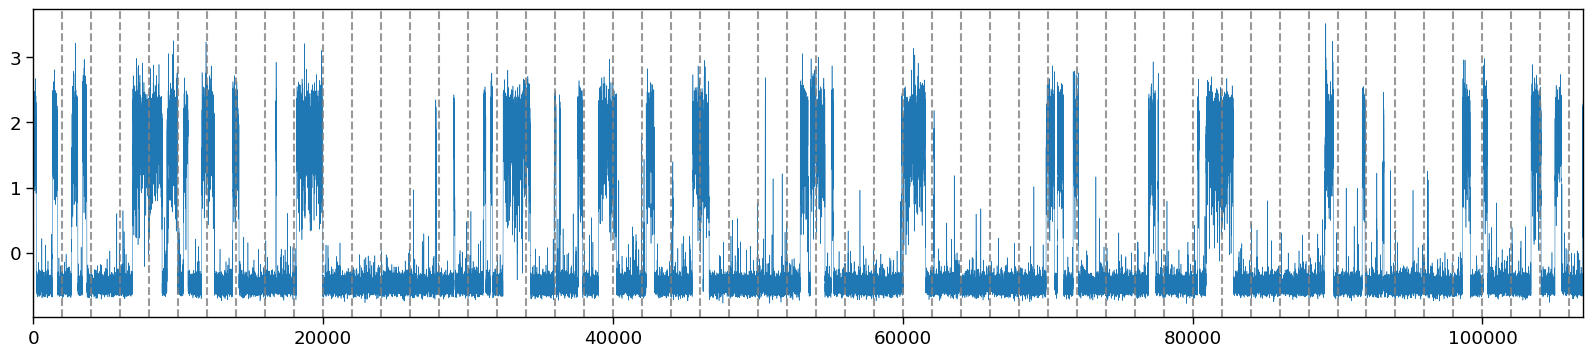

In [33]:
ttrajs_cat = np.concatenate(ttrajs)

with sns.plotting_context('paper',font_scale=1.5):
    fig, ax = plt.subplots(figsize=(20, 4))
    
    ax.plot(ttrajs_cat[:,0], lw=0.4, label='IC1')
    ax.set_xlim([0, ttrajs_cat.shape[0]])
    
    for i in range(0, len(ftrajs_cat), 2000):
        ax.axvline(i, ls='--', lw=1.5, c='gray', alpha=0.8)

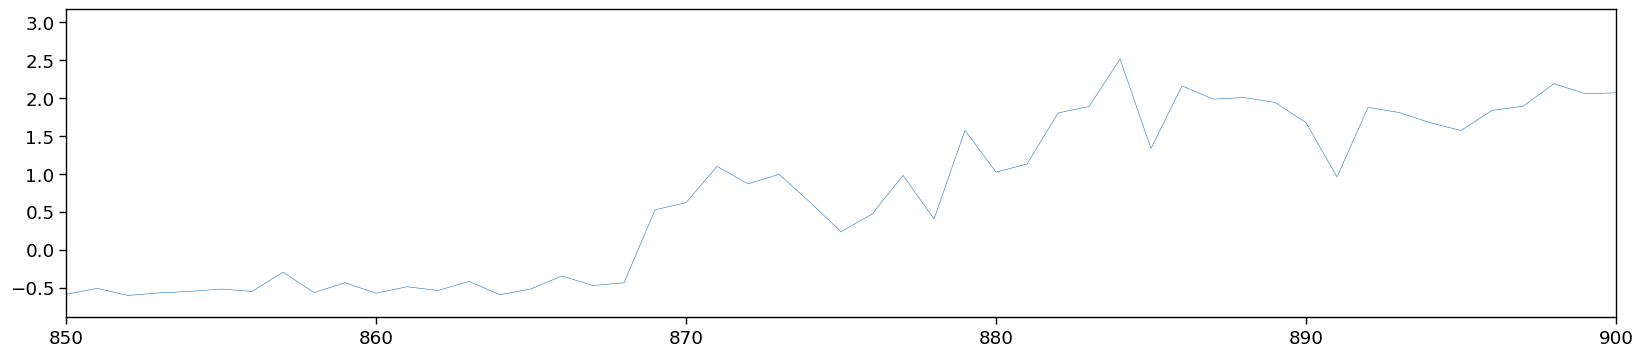

In [34]:
with sns.plotting_context('paper',font_scale=1.5):
    fig, ax = plt.subplots(figsize=(20, 4))
    
    ax.plot(ttrajs[3][:,0], lw=0.4, label='IC1')
    ax.set_xlim([850, 900])

In [25]:
# Initial path from md

t_traj = md.load(traj_paths[3], top=top_path)
transition_traj = t_traj[850:890]
transition_traj.superpose(transition_traj[0])
transition_traj.save(r'./data/init_paths/CLN_md.xtc')

In [78]:
# Define CVs

def tica_cv(snapshot, tica_mod):
    f_snapshot = md.compute_contacts(snapshot, scheme=f_scheme)[0]
    tica_snapshot = tica_mods.transform(f_snapshot)
    return tica_cv

tica = paths.FunctionCV("tica_cv", tica_cv, 
                           tica_mod=tica_mod)

def pcca_cv(snapshot, tica_mod, kmeans_mod, msm):
    f_snapshot = md.compute_contacts(snapshot, scheme=f_scheme)[0]
    tica_snapshot = tica_mods.transform(f_snapshot)
    microstate = kmeans_mod.assign(tica_snapshot)
    pcca = msm.metastable_membership[microstate].flatten()
    return pcca[0]

pcca = paths.FunctionCV("pcca_cv", pcca_cv, 
                        tica_mod=tica_mod,
                        kmeans_mod=kmeans_mod,
                        msm=msm,
                        cv_time_reversible=True)

In [79]:
# Define metastable states hypervolumes
pcca_0_vol = paths.volume.CVDefinedVolume(pcca, lambda_min=0.95, lambda_max=1.00)
pcca_1_vol = paths.volume.CVDefinedVolume(pcca, lambda_min=0.00, lambda_max=0.05)

In [80]:
# Define openmm engine
forcefield = app.ForceField('amber96.xml', 'tip3p.xml')
system = forcefield.createSystem(
    topology=app.PDBFile(top_path).topology, 
    nonbondedMethod=app.PME, 
    nonbondedCutoff=1.0*unit.nanometers,
    constraints=app.HBonds, 
    rigidWater=True,
    ewaldErrorTolerance=0.0005
)

integrator = openmmtools.integrators.VVVRIntegrator(
    300*unit.kelvin,
    1.0/unit.picoseconds,
    2.0*unit.femtoseconds
)
integrator.setConstraintTolerance(0.00001)

In [81]:
openmm_properties = {}
engine_options = {
    'n_frames_max': 2000,
    'n_steps_per_frame': 10
}
ops_topology = ops_openmm.tools.topology_from_pdb(top_path)
engine = ops_openmm.Engine(
    topology=ops_topology, 
    system=system, 
    integrator=integrator, 
    openmm_properties=openmm_properties,
    options=engine_options
)
engine.name = 'TPS MD Engine'

In [82]:
# Define reaction network and shoot mover

network = paths.TPSNetwork(initial_states=pcca_0_vol, final_states=pcca_1_vol)

scheme = paths.OneWayShootingMoveScheme(network=network, 
                                        selector=paths.UniformSelector(),
                                        engine=engine).named("tps_scheme")

In [85]:
# Load trajectory from external files

init_traj = ops_load_trajectory(r'./data/init_paths/CLN_md.xtc', top=r'./data/init_paths/CLN_md/protein.gro')

In [86]:
initial_conditions = scheme.initial_conditions_from_trajectories(init_traj)

# trying strategy #1 `get`: still missing 1 samples
?


AttributeError: 'Snapshot' object has no attribute 'n_residues'

In [87]:
storage = paths.Storage(r"./data/CLN_tps_test.nc", "w", template=init_traj[0])

In [88]:
sampler = paths.PathSampling(storage=storage,
                             move_scheme=scheme,
                             sample_set=initial_conditions)

NameError: name 'initial_conditions' is not defined

In [ ]:
sampler.run(50)

In [ ]:
storage.close()